# Timeseries Forecasting

This notebook explains how to use `tsfresh` in time series foreacasting.
Make sure you also read through the [documentation](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) to learn more on this feature.

It is basically a copy of the other time series forecasting notebook, but this time using more than one 
stock.
This is conceptionally not much different, but the pandas multi-index magic is a bit advanced :-)

We will use the Google, Facebook and Alphabet stock.
Please find all documentation in the other notebook.

In [56]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.ensemble import AdaBoostRegressor
from datetime import datetime

## Reading the data

In [57]:
df = web.DataReader(["AAPL", "GOOG", "MSFT"], 'stooq', start='2010-01-01', end=datetime.now())["Close"]
df.head()

Symbols,AAPL,GOOG,MSFT
Date,,,
2010-01-04,6.52603,NaN,24.3863
2010-01-05,6.53722,NaN,24.3953
2010-01-06,6.43286,NaN,24.2439
2010-01-07,6.42148,NaN,23.9931
2010-01-08,6.46472,NaN,24.1613


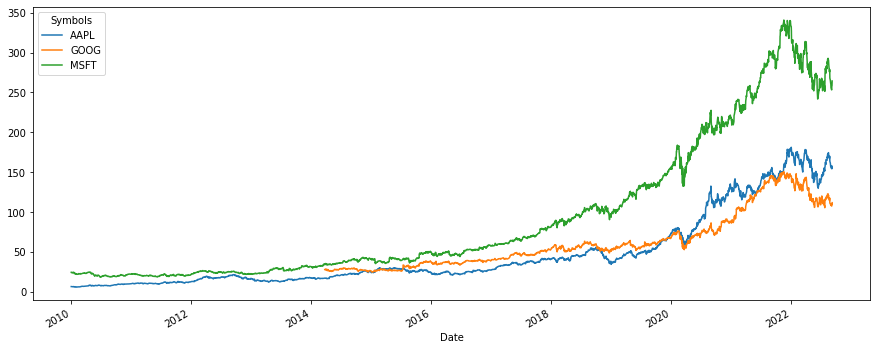

In [58]:
plt.figure(figsize=(15, 6))
df.plot(ax=plt.gca())
plt.show()

This time we need to make sure to preserve the stock symbol information while reordering:

In [63]:
df_melted = df.copy()
df_melted["Date"] = df_melted.index
df_melted = df_melted.melt(id_vars="Date", value_name="Close").sort_values(["Symbols", "Date"])
df_melted = df_melted[["Symbols", "Date", "Close"]]

df_melted

,Symbols,Date,Close
0,AAPL,2010-01-04,6.52603
1,AAPL,2010-01-05,6.53722
2,AAPL,2010-01-06,6.43286
3,AAPL,2010-01-07,6.42148
4,AAPL,2010-01-08,6.46472
...,...,...,...
9577,MSFT,2022-09-02,256.06000
9578,MSFT,2022-09-06,253.25000
9579,MSFT,2022-09-07,258.09000
9580,MSFT,2022-09-08,258.52000


## Create training data sample

In [76]:
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="Date",
                             max_timeshift=50, min_timeshift=10)


c:\Users\Bal\anaconda3\envs\gpu\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 40/40 [00:05<00:00,  6.75it/s]


In [77]:
df_rolled=df_rolled.dropna()

## Extract Features

In [78]:
X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="Date", column_value="Close", 
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 40/40 [02:01<00:00,  3.05s/it]


In [83]:
# split up the two parts of the index and give them proper names
X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=True)
X.index.names = ["symbol", "t0"]

We make the data a bit easier to work with by giving them a multi-index instead ot the tuple index:

In [84]:
X=X.drop(X.columns[X.nunique() <=1], axis=1)

Our `(AAPL, 2020-07-14 00:00:00)` is also in the data again:

In [104]:
events = pd.read_csv('../data/v1/events.csv')
#generate y from events dataset
#extract proper symbol-date combination of events from features


def generate_dataset(events, features):
    features = features.reset_index().sort_values('t0')
    events = events.sort_values('t0')

    features.index = features.symbol.map(str) + '-' + features.t0.dt.date.map(str)
    events.index = events.symbol.map(str) + '-' + events.t0.map(str)

    idx = events.index.intersection(features.index)
    Xy = features.loc[idx]
    Xy['y']= events.loc[idx].result.apply(lambda x : x > 0).astype(int)

    return Xy
    

Xy = generate_dataset(events, X)

Xy.to_csv('../data/v1/dataset.csv')

In [133]:
y = Xy['y']
X = Xy.drop(['y','symbol', 't0'],axis=1)

In [134]:
X

,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,Close__median,...,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,"Close__matrix_profile__feature_""min""__threshold_0.98","Close__matrix_profile__feature_""max""__threshold_0.98","Close__matrix_profile__feature_""mean""__threshold_0.98","Close__matrix_profile__feature_""median""__threshold_0.98","Close__matrix_profile__feature_""25""__threshold_0.98","Close__matrix_profile__feature_""75""__threshold_0.98",Close__mean_n_absolute_max__number_of_maxima_7
MSFT-2010-03-23,0.0,0.0,0.0,1.0,1168.88460,2.681334e+04,0.206210,-0.012366,0.005353,22.82030,...,3.383975,3.647820,3.733422,0.892265,3.449372,1.911923,1.776396,1.323881,2.377316,24.176971
AAPL-2010-03-24,0.0,0.0,0.0,0.0,324.43514,2.069655e+03,0.087546,0.011728,0.001048,6.33450,...,3.296960,3.617684,3.733422,0.892265,3.449372,1.911923,1.776396,1.323881,2.377316,6.900759
AAPL-2010-06-09,0.0,0.0,0.0,0.0,390.13369,2.989332e+03,0.130021,0.006601,-0.002984,7.60264,...,3.083642,3.534660,3.745049,0.892265,3.449372,1.911923,1.776396,1.323881,2.377316,8.141419
MSFT-2010-06-28,1.0,0.0,0.0,1.0,1116.08920,2.459220e+04,0.314550,-0.100254,-0.004755,21.16370,...,3.034826,3.371096,3.579389,1.167645,4.382300,2.132487,1.912543,1.456364,2.435174,24.561543
AAPL-2010-08-24,0.0,0.0,0.0,0.0,400.28278,3.144697e+03,0.097544,-0.008748,-0.003531,7.87067,...,3.333686,3.606309,3.714243,0.740321,3.421021,1.878180,1.872347,1.432063,2.443155,8.269114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSFT-2022-02-23,1.0,0.0,0.0,0.0,15869.30900,4.952185e+06,4.721380,-1.225740,-0.043867,308.96300,...,3.309947,3.666582,3.775856,0.892265,3.449372,1.911923,1.776396,1.323881,2.377316,338.251143
AAPL-2022-03-14,1.0,0.0,0.0,1.0,8552.60600,1.436634e+06,2.472000,-0.545440,-0.035367,168.39600,...,3.249102,3.623566,3.733422,0.892265,3.449372,1.911923,1.776396,1.323881,2.377316,177.173714
GOOG-2022-04-11,1.0,0.0,0.0,0.0,6940.01900,9.456222e+05,2.424880,-0.069880,-0.067571,135.69800,...,3.503430,3.798505,3.806662,0.892265,3.449372,1.911923,1.776396,1.323881,2.377316,143.598429
MSFT-2022-06-10,1.0,0.0,0.0,0.0,14093.81900,3.907947e+06,5.441160,-1.200280,-0.063765,273.51100,...,3.621412,3.798505,3.806662,0.892265,3.449372,1.911923,1.776396,1.323881,2.377316,306.962000


Just to repeat: the features in this row were only calculated using the time series values of `AAPL` up to and including `2015-07-15` and the last 20 days.

## Prediction

The next line might look like magic if you are not used to pandas transformations, but what it does is:

for each stock symbol separately:
* sort by date
* take the high value
* shift 1 time step in the future
* bring into the same multi-index format as `X` above

In [35]:
y = df_melted.groupby("Symbols").apply(lambda x: x.set_index("Date")["Close"].shift(-1)).T.unstack()

Quick consistency test:

In [36]:
y["AAPL", pd.to_datetime("2020-07-13")], df.loc[pd.to_datetime("2020-07-14"), "AAPL"]

(95.727, 95.727)

In [37]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [127]:
Xy.shape

(125, 463)

The splitting into train and test samples workes in principle the same as with a single identifier, but this time we have a multi-index symbol-date, so the `loc` call looks a bit more complicated:

In [135]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [136]:
X_train_selected = select_features(X_train, y_train)

In [137]:
X_train.shape

(100, 460)

We are training a regressor for each of the stocks separately

Now lets check again how good our prediction is:

In [182]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

gbm = lgb.LGBMClassifier(num_leaves=2,
                        learning_rate=1,
                        class_weight='balanced',
                        n_estimators=40)

gbm.fit(X_train.to_numpy(), y_train.to_numpy(),
        eval_set=[(X_test.to_numpy(), y_test.to_numpy())],
        callbacks=[lgb.early_stopping(100000)])

Training until validation scores don't improve for 100000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.501143


LGBMClassifier(class_weight='balanced', learning_rate=1, n_estimators=40,
               num_leaves=2)

In [183]:
y_pred = gbm.predict(X_test.to_numpy(), num_iteration=gbm.best_iteration_)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [184]:
from sklearn.metrics import classification_report

print(classification_report(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.84      1.00      0.91        21

    accuracy                           0.84        25
   macro avg       0.42      0.50      0.46        25
weighted avg       0.71      0.84      0.77        25



c:\Users\Bal\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Bal\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Bal\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [181]:
estimator = lgb.LGBMClassifier(
                        class_weight='balanced')
param_grid = {
    'learning_rate': [0.01, 0.1, 1, 2],
    'n_estimators': [20, 40, 60, 100, 200, 500],
    'num_leaves': [2, 4, 8, 16, 32],
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train.to_numpy(), y_train.to_numpy())

print(f'Best parameters found by grid search are: {gbm.best_params_}')

Best parameters found by grid search are: {'learning_rate': 1, 'n_estimators': 40, 'num_leaves': 2}
